# Result comparaison for Superpixels Entropy

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import EntropyRateSuperpixel as ERS
import MyDataset as Data

from SSGA import SSGA

145 145 200


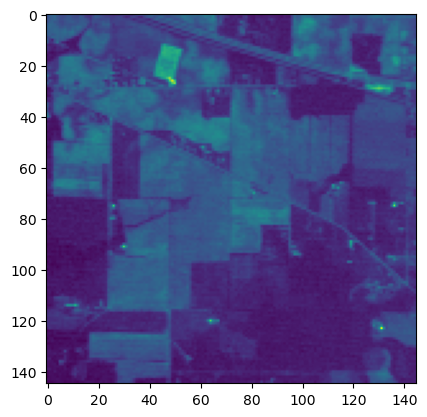

In [2]:
usedDataset = Data.IndianPines
#usedDataset = Data.PaviaUniversity
#usedDataset = Data.PaviaCenter


N,M,B = usedDataset["shape"]
trainData = usedDataset["data"]
print(N,M,B)

def crop_img(size):
    size = min(size, N, M)
    if size!=N and size!=M:
        xStart = np.random.randint(0, N-1-size)
        yStart = np.random.randint(0, M-1-size)
        trainData = usedDataset["data"][xStart:xStart+size, yStart:yStart+size, :]
        trainData = Data.standardize_data(trainData)
        N,M,B = trainData.shape
    return trainData

#trainData = crop_img(400)

b = np.random.randint(0, B-1)
plt.imshow(trainData[:,:,b])
plt.show()


gamma = 0.15
def computePs(K, N, M):
    return int(N*M/K * 1/np.log(np.log(N*M/K)) * gamma)

## Finding $\lambda$ coefficient

In [3]:
def find_lambda_coeff(data, K, mini, maxi, similarity_function, Ps, print_info=False):
    def aux(i,j, SP):
        coeff = int((i+j)/2)
        if print_info:
            print("finding lambda coeff:", coeff)
        if i>=j:
            return SP, max(coeff,1)
        
        SP = ERS.find_superpixel(data, K, coeff, similarity_function)
        minSPsize = min([len(l) for l in SP])
        if minSPsize==Ps:
            return SP, coeff
        elif minSPsize<Ps:
            return aux(coeff+1, j, SP)
        else:
            return aux(i, coeff-1, SP)
        
    return aux(mini, maxi, None)

## Compute SPs

In [ ]:
RunDataFormat = False
useLambdasModel = True

import json
datasetFolder = "datasets/"
saved_file_name = {
    True: "FormatDataSuperpixels",
    False: "SimFunSuperpixels"
}

complete_save_file_name = datasetFolder + saved_file_name[RunDataFormat]
if useLambdasModel:
    complete_save_file_name += "UsedLambdasModel"
complete_save_file_name +=  usedDataset["name"] +".json"
print(complete_save_file_name)

datasets/SimFunSuperpixelsIndian Pines.json


In [7]:
if RunDataFormat:
    data1 = usedDataset["data"].copy()
    data2 = Data.normalized_data(usedDataset["data"].copy())
    data3 = Data.standardize_data( usedDataset["data"].copy() )
    datas = [data1, data2, data3]
    names = ["Basic", "Normalized", "Standardized"]

    # Values found with find_lambda_coeff function
    IndianLambdaCoeffDatas = {
        100:[1, 17, 34],
        200:[1, 33, 72],
        300:[1, 52, 110],
        400:[1, 59, 150],
        500:[1, 78, 187],
        600:[1, 94, 230],
        700:[1, 133, 275]
    }
    UniversityLambdaCoeffDatas = {
        100:[1, 17, 42],
        200:[1, 32, 84],
        300:[1, 47, 123],
        400:[1, 60, 166],
        500:[1, 81, 210],
        600:[1, 97, 251],
        700:[1, 111, 300]
    }

    LambdaCoeffs = {
        Data.IndianPines["name"]: IndianLambdaCoeffDatas,
        Data.PaviaUniversity["name"]: UniversityLambdaCoeffDatas
    }

else:
    datas = [ERS.complete_basic_similarity,
                        ERS.complete_norm2_similarity,
                        ERS.complete_norm1_similarity]
    names = ["Basic", "(.)²", "|.|"]

    trainData = Data.standardize_data(usedDataset["data"])

    # Values found with find_lambda_coeff function
    IndianLambdaCoeffDatas = {
        #50: [17, 27, 15],
        100:[34, 58, 31],
        200:[72, 114, 70],
        300:[110, 179, 102],
        400:[150, 242, 141],
        500:[187, 308, 180],
        600:[230, 379, 217]
    }
    UniversityLambdaCoeffDatas = {
        100:[42, 59, 44],
        200:[84, 121, 92],
        300:[123, 185, 140],
        400:[166, 255, 184],
        500:[210, 331, 236],
        600:[251, 404, 280],
        700:[300, 481, 325]
    }

    PaviaCenterLambdaCoeff = {
    145:{
        100: [[50, 63, 51],
              [36, 60, 36],
              [40, 58, 38],
              [40, 62, 43],
              [36, 62, 40]],

        300: [[162, 238, 159],
              [121, 196, 118],
              [123, 200, 120],
              [125, 198, 139],
              [113, 219, 125]]
    },
    200:{
        100: [[38, 60, 40],
              [40, 60, 40],
              [38, 60, 43],
              [38, 62, 46]],

        300: [[123, 200, 120],
              [125, 186, 121],
              [123, 195, 133],
              [118, 220, 152]]
    },
    400:{
        100: [[44, 66, 47],
              [46, 58, 46],
              [46, 64, 46]],
        300: [[130, 196, 146],
              [144, 180, 142],
              [144, 219, 149]]
    },
    600:{
        100: [[49, 62, 46]],
        300: [[144, 181, 144]]
    }
}


for size, dic in PaviaCenterLambdaCoeff.items():
    for K in dic.keys():
        dic[K] = np.array(dic[K])

    LambdaCoeffs = {
        Data.IndianPines["name"]: IndianLambdaCoeffDatas,
        Data.PaviaUniversity["name"]: UniversityLambdaCoeffDatas
    }

Ks = list(LambdaCoeffs[usedDataset["name"]].keys())

In [8]:
def findLambdaByCroping(data, simFun, nbCroping, n, m):
    # Didn't performmed well
    N,M,B = data.shape
    sum_lambda = 0

    K = 100
    a = int(20*K/100)
    b = int(60*K/100)
    for _ in range(nbCroping):
        xStart = np.random.randint(0, N-1-n)
        yStart = np.random.randint(0, M-1-m)
        trainData = Data.standardize_data(data)[xStart:xStart+n, yStart:yStart+m, :]
        plt.imshow(trainData[:,:,1])
        plt.show()
        Ps = computePs(K, N, M)
        _, coeff = find_lambda_coeff(trainData, K, a, b, simFun, Ps, True)
        print(coeff)
        sum_lambda += coeff
    
    return sum_lambda/nbCroping
        

#print(findLambdaByCroping(usedDataset["data"], datas[2], 4, 150, 150))

In [95]:
def getLambdaAverage(K,N,M):
    return 0.38 * gamma* K * np.log(N*M*K)**0.668

def getLambdaNorm2(K,N,M):
    return 1.214 * gamma* K * np.log(N*M*K)**0.444

def getLambdaNorm1(K,N,M):
    return 0.176* gamma* K * np.log(N*M)**1.147



getLambdas = [getLambdaAverage, getLambdaNorm2, getLambdaNorm1]

In [ ]:
SPsDic = {}
for K in Ks:
    print("K:", K)
    Ps = computePs(K, N, M)

    current_list = []
    for i,data in enumerate(datas):
        print(i, end=" ")
        if RunDataFormat:
            SPs, coeff = find_lambda_coeff(data, K, 1, 400, ERS.complete_basic_similarity, Ps)
            print("Choosen Coef:", coeff)
            #SPs = ERS.find_superpixel(data, K, LambdaCoeffs[usedDataset["name"]][K][i], ERS.complete_basic_similarity, True)
        else:
            if useLambdasModel:
                Sps = ERS.find_superpixel(trainData, K, int(getLambdas[i](K,N,M)), data, True)
            else:
                SPs, coeff = find_lambda_coeff(trainData, K, 1, 500, data, Ps)
                print("Choosen Coef:", coeff)
                #SPs = ERS.find_superpixel(trainData, K, LambdaCoeffs[usedDataset["name"]][K][i], data, True)
        current_list.append(SPs)
    print()
    SPsDic[K] = current_list

json_object = json.dumps(SPsDic)
with open(complete_save_file_name, "w") as f :
    f.write(json_object)
    f.close()

K: 100
0 1 2 
K: 200
0 1 2 
K: 300
0 1 2 
K: 400
0 1 2 
K: 500
0 1 2 
K: 600
0 1 2 
K: 700
0 1 2 


In [9]:
with open(complete_save_file_name, "r") as f:
    tempDic = json.load(f)
    f.close()
SPsDic = {}
for key, dataListe in tempDic.items():
    SPsDic[int(key)] = [[[tuple(coor) for coor in SP] for SP in SPsListe] for SPsListe in dataListe]

### Modeling $\lambda$

model n°1:
    0.9928504152227402
    params: 0.17589681312745964 1.147110655433204
model n°2:
    0.9900290964027333
    params: 0.19315856656243388 0.48601336787034044
model n°3:
    0.9906733000127408
    params: 0.29486728136974927 0.7715957251315682
model n°4:
    0.9863173844878917
    params: 0.04116810405668478 1.4810486416433957
model n°5:
    0.9863263538560535
    params: 0.0050864715251734294 4.21678379077871


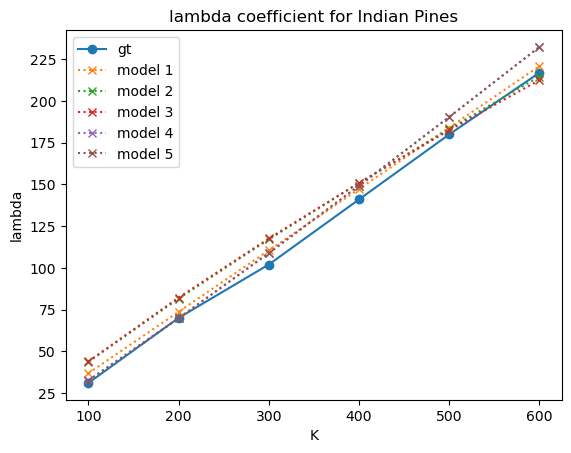

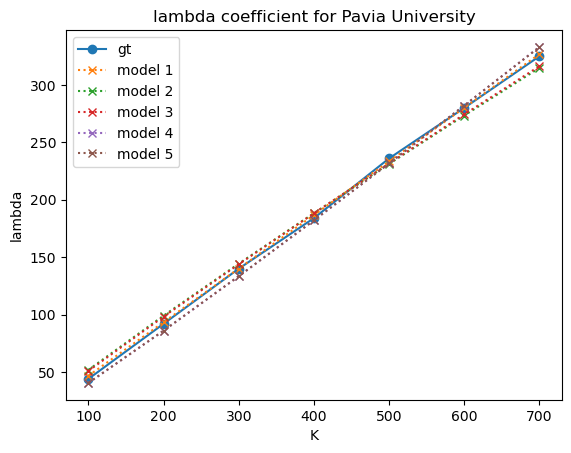

In [33]:
from scipy.optimize import curve_fit

usedSimFun = 2

points = []
for dataset in [Data.IndianPines, Data.PaviaUniversity]:
    n, m, _ = dataset["data"].shape
    for K in LambdaCoeffs[dataset["name"]].keys():
        points.append((n*m, K, LambdaCoeffs[dataset["name"]][K][usedSimFun]))

for size, dic in PaviaCenterLambdaCoeff.items():
    for K in dic.keys():
        point = (size**2, K, np.average(dic[K][:,usedSimFun]))
        points.append(point)

points = np.array(points)
xy = (points[:,0], points[:,1])
z = points[:,2]

def r2_score(z_true, z_pred):
    ss_res = np.sum((z_true - z_pred) ** 2)
    ss_tot = np.sum((z_true - np.mean(z_true)) ** 2)
    return 1 - ss_res / ss_tot



def model1(xy, a, b):
    x,y = xy
    return a*y* gamma* np.log(x)**b

def model2(xy, a, b):
    x,y= xy
    return a * y *np.log(x/y)**b

def model3(xy, a, b):
    x,y= xy
    return a * y *np.log(np.log(x/y))**b

def model4(xy, a, b):
    x,y = xy
    return a * gamma* y * np.log(x*y)**b

def model5(xy, a, b):
    x,y = xy
    return a * y * np.log(np.log(x*y))**b



models = [model1, model2, model3, model4, model5]

popts = []
for i,fun in enumerate(models):
    popt, _ = curve_fit(fun, xy, z)
    popts.append(popt)

    z_pred = models[i](xy, *popts[i])
    print("model n°" + str(i+1)+":")
    print("   ", r2_score(z, z_pred))
    print("   ", "params:", *popts[i])


for dataset in [Data.IndianPines, Data.PaviaUniversity]:
    n, m, _ = dataset["data"].shape
    new_Ks = LambdaCoeffs[dataset["name"]].keys()
    plt.plot(new_Ks, [LambdaCoeffs[dataset["name"]][K][usedSimFun] for K in new_Ks], "-o", label="gt")
    
    for i, fun in enumerate(models):
        x_temp = np.array([n*m for K in new_Ks])
        y_temp = np.array([K for K in new_Ks])
        xy_temp = (x_temp, y_temp)
        plt.plot(new_Ks, models[i](xy_temp, *popts[i]), ":x", label="model "+str(i+1))

    maxi = max(max(new_Ks), max([LambdaCoeffs[dataset["name"]][K][i] for K in new_Ks for i in range(len(datas))]))
    #plt.plot(maxi,maxi, "")
    plt.xlabel("K")
    plt.ylabel("lambda")
    plt.title("lambda coefficient for " + dataset["name"])
    plt.legend()
    plt.show()

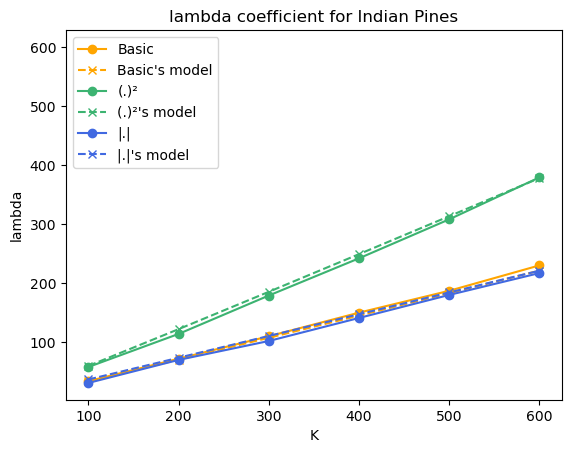

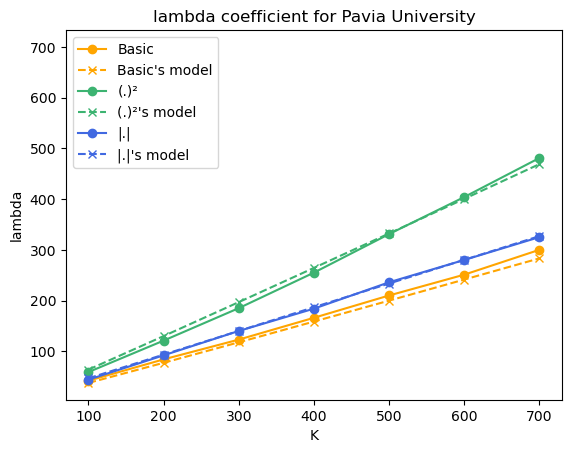

In [41]:
colors = ["orange", "mediumseagreen", "royalblue"]

for dataset in [Data.IndianPines, Data.PaviaUniversity]:
    n, m, _ = dataset["data"].shape
    new_Ks = LambdaCoeffs[dataset["name"]].keys()
    for i in range(len(datas)):
        plt.plot(new_Ks, [LambdaCoeffs[dataset["name"]][K][i] for K in new_Ks], "-o", label=names[i], color=colors[i])
        plt.plot(new_Ks, [getLambdas[i](K, n, m) for K in new_Ks], "--x", label=names[i]+"'s model", color=colors[i])

    maxi = max(max(new_Ks), max([LambdaCoeffs[dataset["name"]][K][i] for K in new_Ks for i in range(len(datas))]))
    plt.plot(maxi,maxi, "")
    plt.xlabel("K")
    plt.ylabel("lambda")
    plt.title("lambda coefficient for " + dataset["name"])
    plt.legend()
    plt.show()

### Superpixels Classifier

In [57]:
class Superpixel:
    def __init__(self, liste, labels, gt, counting0=True):
        self.labels = [l for l in labels if not(not counting0 and l==0)]
        self.pixels = [coor for coor in liste if not(not counting0 and gt[coor]==0)]

        self.class_count = {l:0 for l in self.labels}
        for coor in self.pixels:
            self.class_count[gt[coor]] += 1

        self.guess = self.labels[0]
        for l in self.labels:
            if self.class_count[l] > self.class_count[self.guess]:
                self.guess = l

        self.proportion = self.class_count[self.guess]/len(self.pixels)
        self.isSingleClass = self.class_count[self.guess] == len(self.pixels)




class SuperpixelClassifier:
    def __init__(self, liste, labels, gt, counting0=True):
        self.counting0 = counting0
        self.labels = [l for l in labels if not(not counting0 and l==0)]

        self.liste = []
        self.pixels = []
        for l in liste:
            new_list = [coor for coor in l if not(not counting0 and gt[coor]==0)]
            if new_list!=[]:
                self.liste.append(new_list)
                self.pixels += new_list

        self.SPs:list[Superpixel] = [Superpixel(l, self.labels, gt, counting0) for l in self.liste]
        self.association:dict[tuple[int,int], Superpixel] = {}
        for i,SP in enumerate(self.SPs):
            for coor in SP.pixels:
                self.association[coor] = i

        self.data_class = {l:[] for l in labels}
        self.guess_map = np.zeros(gt.shape, dtype=int)
        for x,y in self.pixels:
            g = self.guess(x,y)
            self.guess_map[x,y] = g
            self.data_class[g].append((x,y))

    
    def getSP(self, x,y) -> Superpixel:
        return self.SPs[self.association[(x,y)]]
    

    def guess(self, x,y):
        return self.getSP(x,y).guess


    def predict(self, liste):
        return [self.guess(x,y) for x,y in liste]
    
    
    def accuracy(self, samples, labels):
        assert len(samples)==len(labels)
        prediction = self.predict(samples)
        return len([i for i in range(len(samples)) if prediction[i]==labels[i]])
    

    def singleClassCount(self):
        return len([i for i in range(len(self.SPs)) if self.SPs[i].isSingleClass])
    
    def singleClassProportion(self):
        return self.singleClassCount()/len(self.SPs)
    

    def averageProportion(self):
        return np.average([SP.proportion for SP in self.SPs])

    
    def labelAccuracy(self, data_class, label):
        if label not in self.labels:
            return False
        goodGuessCount = 0
        for x,y in data_class[label][1]:
            if self.guess_map[x,y] == label:
                goodGuessCount += 1
        return goodGuessCount/len(data_class[label][1])
    
    def overallAccuracy(self, gt):
        goodGuessCount = 0
        for x,y in self.pixels:
            if gt[x,y] == self.guess_map[x,y]:
                goodGuessCount +=1
        return goodGuessCount/len(self.pixels)
    

    def averageAccuracy(self, gt):
        dic = {l:[0,0] for l in self.labels}
        for x,y in self.pixels:
            l = gt[x,y]
            dic[l][0] += 1
            if l==self.guess(x,y):
                dic[l][1] += 1
        
        return sum([e[1]/e[0] for e in dic.values()])/len(self.labels)
    


    def jaccard(self, gt, data_class, label, returnWeight=False):
        liste = data_class[label][1]
        if not self.counting0:
            liste = [coor for coor in liste if gt[coor]!=0]
            
        self_set = set(self.data_class[label])
        data_set = set(liste)
        inter = len(data_set.intersection(self_set))
        union = len(data_set.union(self_set))

        if returnWeight:
            return inter/union, len(liste)
        return inter/union
    
    
    def averageWeightedJaccard(self, gt, data_class):
        sum = 0
        for l in self.labels:
            jacc, weight = self.jaccard(gt, data_class, l, returnWeight=True)
            sum += weight*jacc
        return sum/len(self.labels)


In [58]:
ClassifierDic:dict[int, list[SuperpixelClassifier]] = {}

for b in [True, False]:
    ClassifierDic[b] = {}
    for K in Ks:
        ClassifierDic[b][K] = [
            SuperpixelClassifier(SPs, usedDataset["labels"], usedDataset["gt"], counting0=b)
                    for SPs in SPsDic[K]
            ]

### Visual result

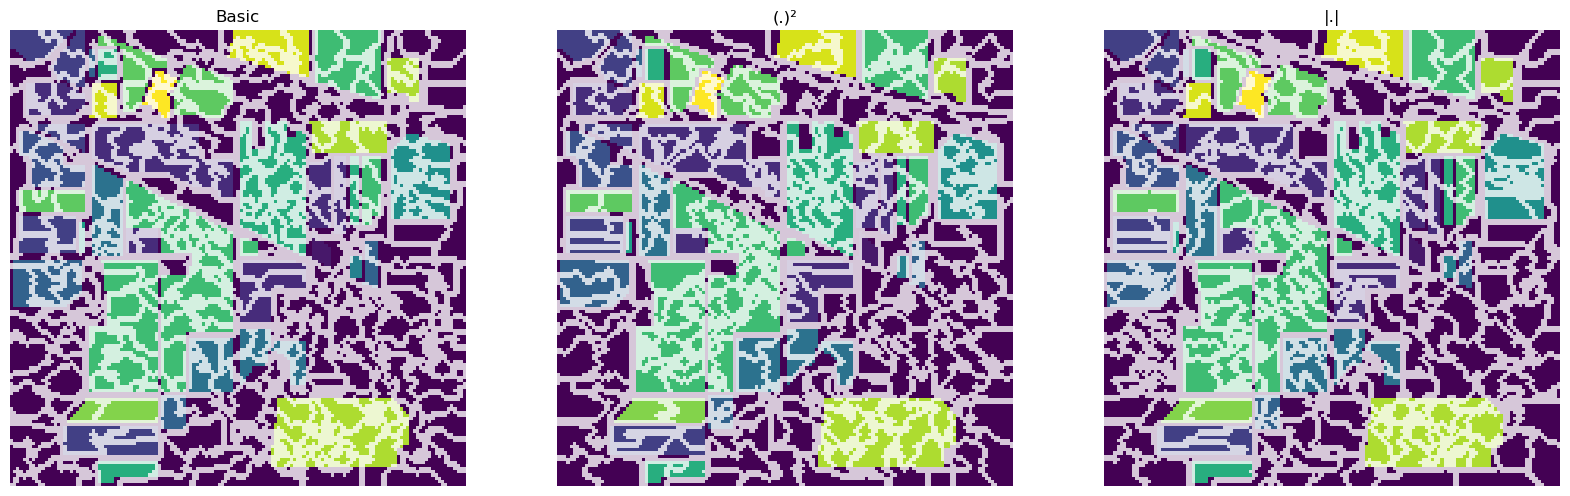

True


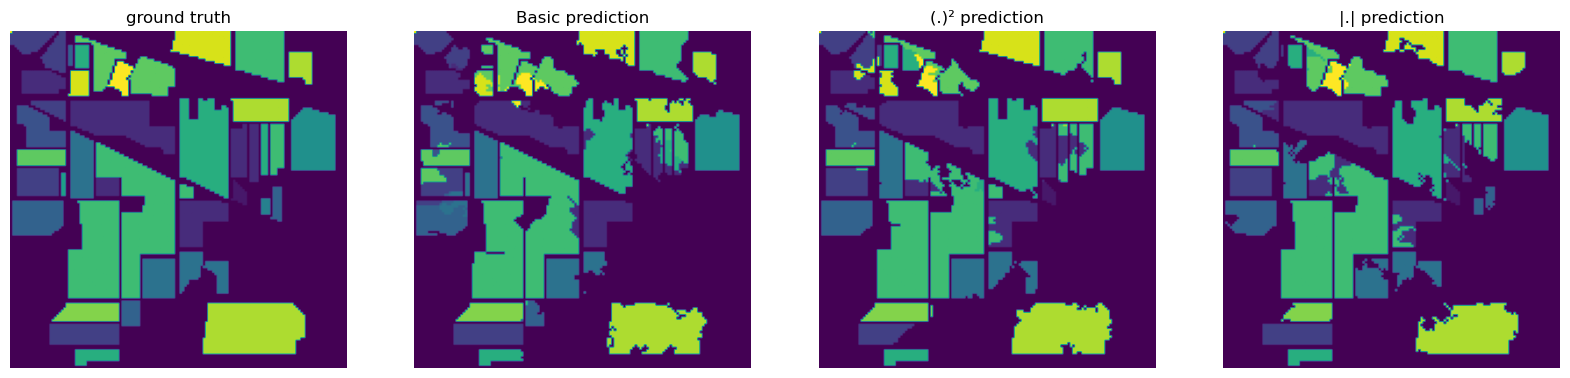

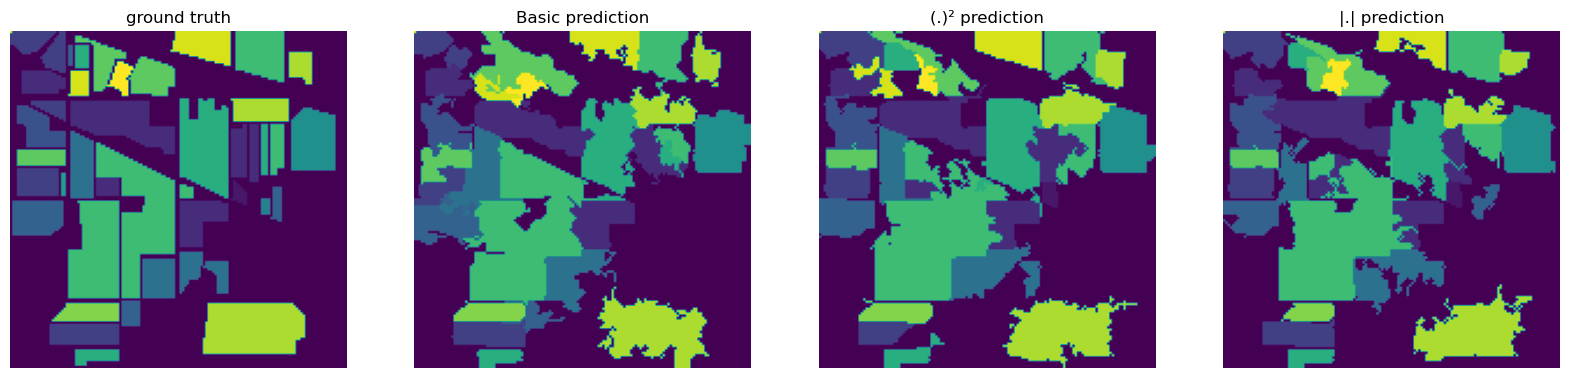

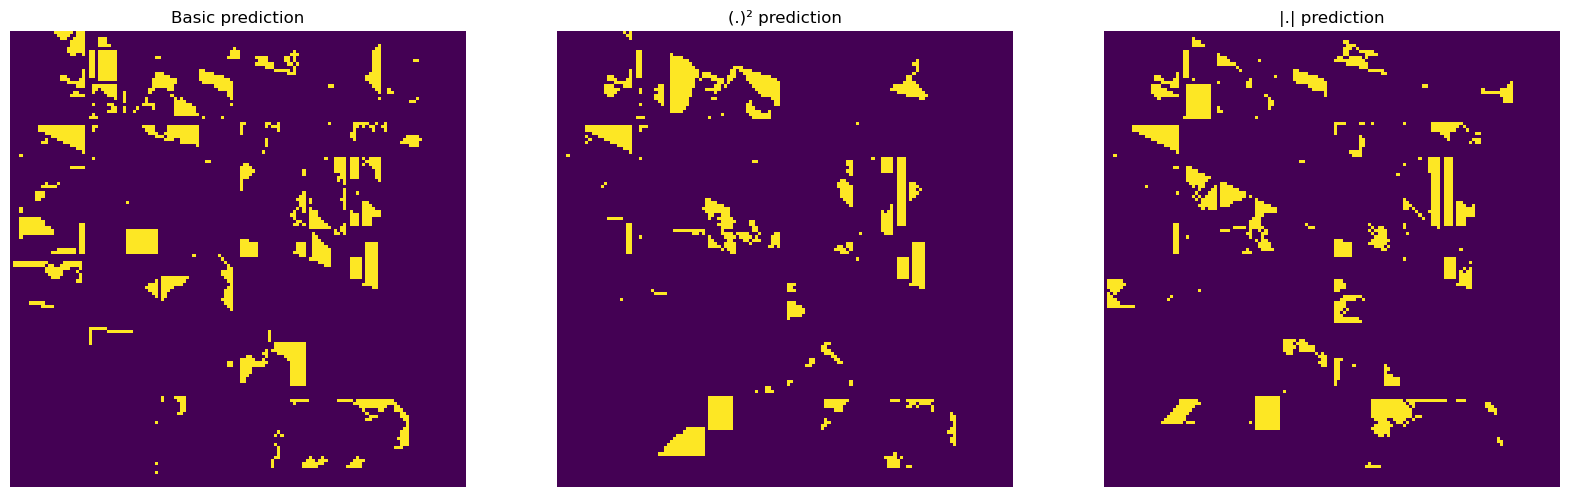

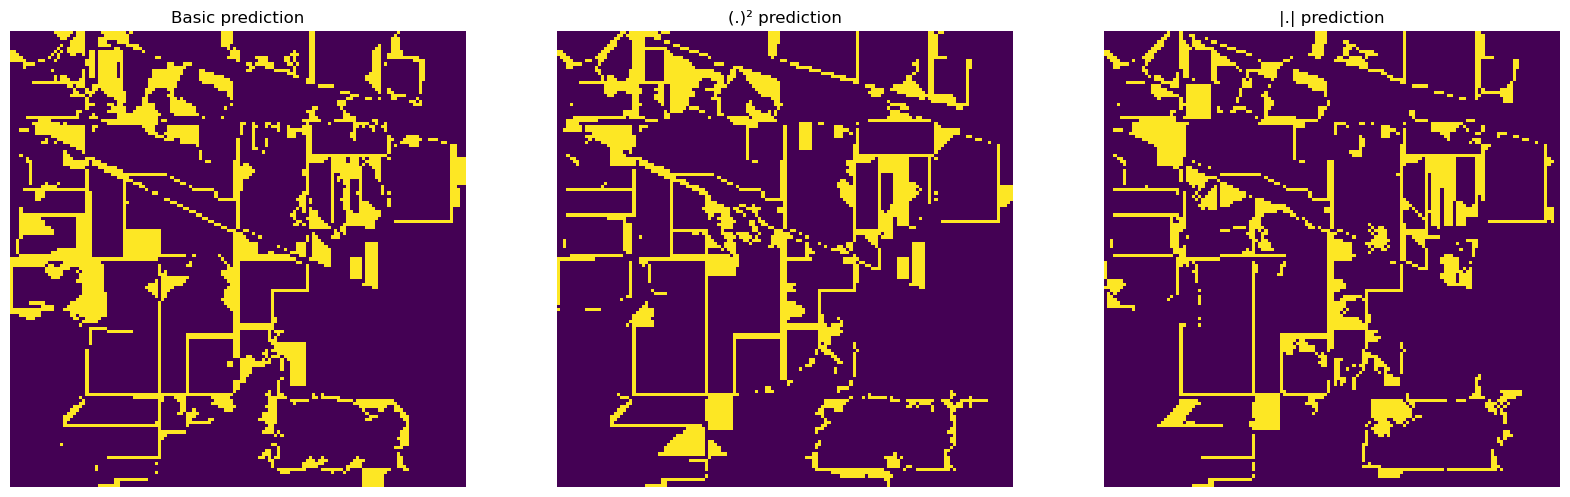

False


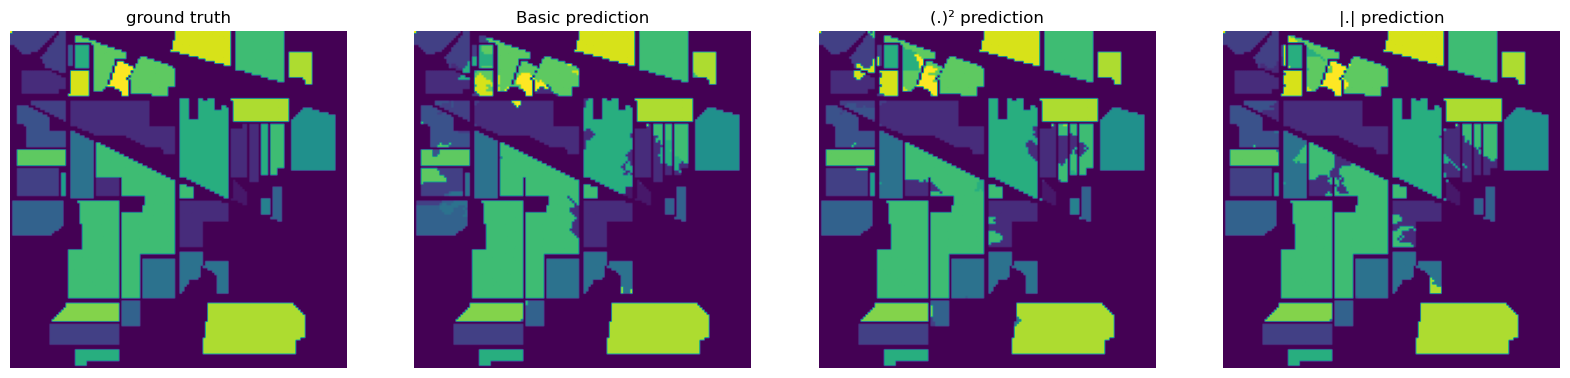

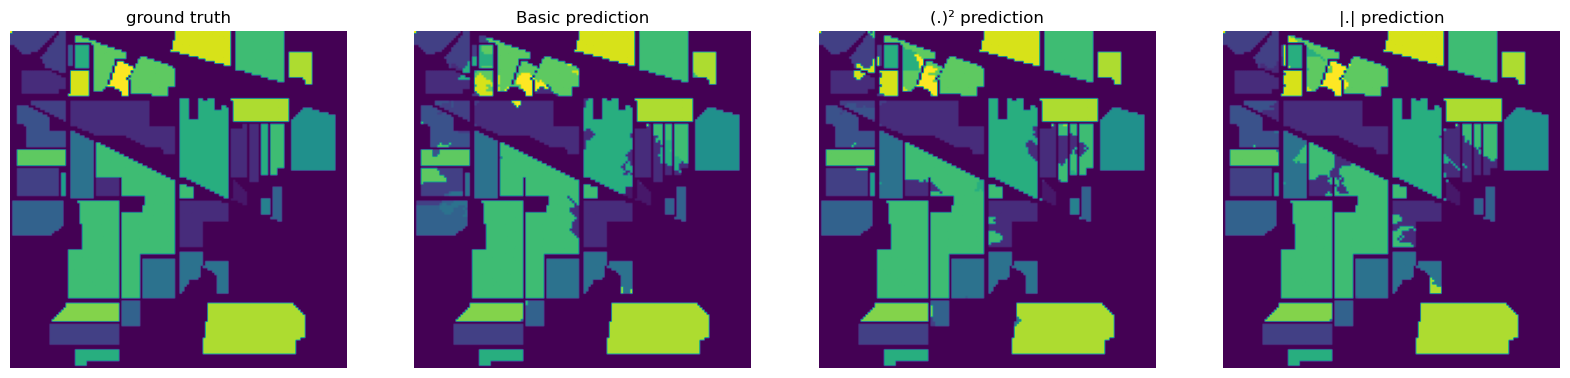

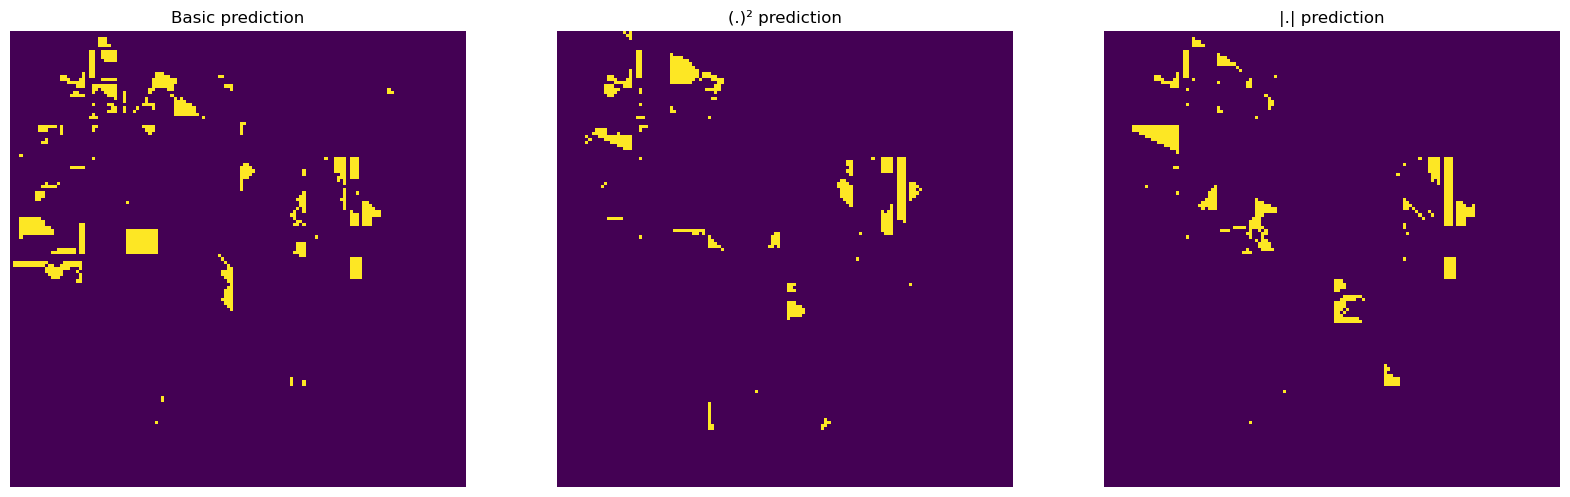

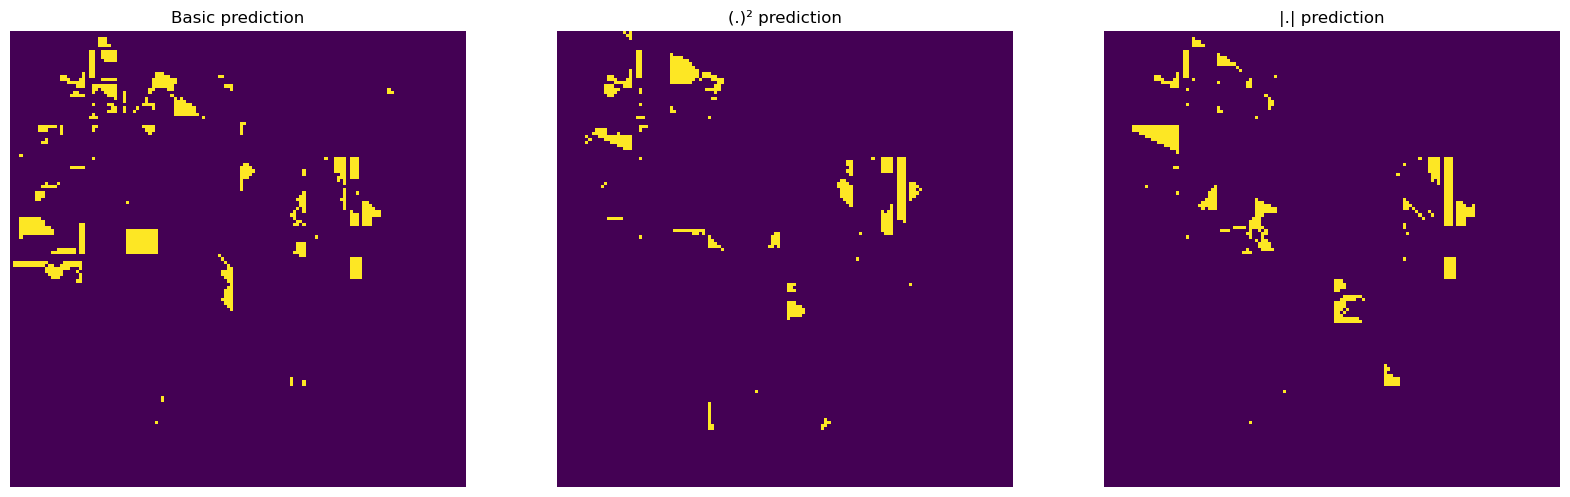

In [59]:
K = 200

fig, axs = plt.subplots(1, len(SPsDic[K]))
fig.set_size_inches(20,30)
for i,SP in enumerate(SPsDic[K]):
    axs[i].imshow(usedDataset["gt"])
    axs[i].imshow(ERS.create_overlay_borders(usedDataset["gt"], SP, color=[255,255,255,200]))
    axs[i].title.set_text(names[i])
    axs[i].axis("off")
plt.show()



for b in [True, False]:
    print(b)
    classifiers = ClassifierDic[b][K]

    imgs = [usedDataset["gt"]] + [C.guess_map for C in classifiers]
    titles = ["ground truth"] + [name+" prediction" for name in names]


    fig, axs = plt.subplots(1, len(classifiers)+1)
    fig.set_size_inches(20,30)
    for i in range(len(imgs)):
        new_img = imgs[i].copy()
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]==0:
                    new_img[x,y] = 0
        new_img[0,0] = max(usedDataset["labels"])
        axs[i].imshow(new_img)
        axs[i].title.set_text(titles[i])
        axs[i].axis("off")
    plt.show()


    fig, axs = plt.subplots(1, len(classifiers)+1)
    fig.set_size_inches(20,30)
    for i in range(len(imgs)):
        new_img = imgs[i].copy()
        new_img[0,0] = max(usedDataset["labels"])
        axs[i].imshow(new_img)
        axs[i].title.set_text(titles[i])
        axs[i].axis("off")
    plt.show()


    fig, axs = plt.subplots(1, len(classifiers))
    fig.set_size_inches(20,30)
    for i in range(1, len(imgs)):
        new_img = np.zeros((N,M))
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]!=0 and usedDataset["gt"][x,y]!=imgs[i][x,y]:
                    new_img[x,y] = 1

        axs[i-1].imshow(new_img)
        axs[i-1].title.set_text(titles[i])
        axs[i-1].axis("off")
    plt.show()

    fig, axs = plt.subplots(1, len(classifiers))
    fig.set_size_inches(20,30)
    for i in range(1, len(imgs)):
        new_img = np.zeros((N,M))
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]!=imgs[i][x,y]:
                    new_img[x,y] = 1

        axs[i-1].imshow(new_img)
        axs[i-1].title.set_text(titles[i])
        axs[i-1].axis("off")
    plt.show()


### Classification result

In [60]:
size = len(ClassifierDic[True][Ks[0]])
overallAccuracys = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageAccuracys = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageWeigthedJaccard = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
singleClassCounts = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageProportions = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}

labelsAccuracy = {b:{
        l:{K:[0 for _ in range(size)] for K in Ks} for l in usedDataset["labels"]
    } for b in [True, False]}
labelsJaccard = {b:{
        l:{K:[0 for _ in range(size)] for K in Ks} for l in usedDataset["labels"]
    } for b in [True, False]}

for b in [True, False]:
    print(b)
    for K in Ks:
        for i,C in enumerate(ClassifierDic[b][K]):
            overallAccuracys[b][K][i] = C.overallAccuracy(usedDataset["gt"])
            averageAccuracys[b][K][i] = C.averageAccuracy(usedDataset["gt"])
            averageWeigthedJaccard[b][K][i] = C.averageWeightedJaccard(usedDataset["gt"], usedDataset["class"])
            singleClassCounts[b][K][i] = C.singleClassProportion()
            averageProportions[b][K][i] = C.averageProportion()
        
            for label in usedDataset["labels"]:
                if label in C.labels:
                    labelsAccuracy[b][label][K][i] = C.labelAccuracy(usedDataset["class"], label)
                    labelsJaccard[b][label][K][i] = C.jaccard(usedDataset["gt"], usedDataset["class"], label)
        

True
False


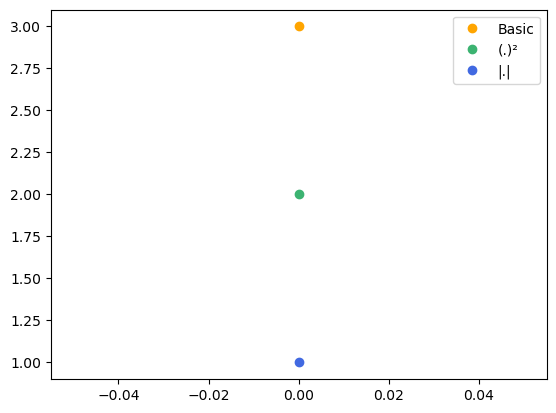

True


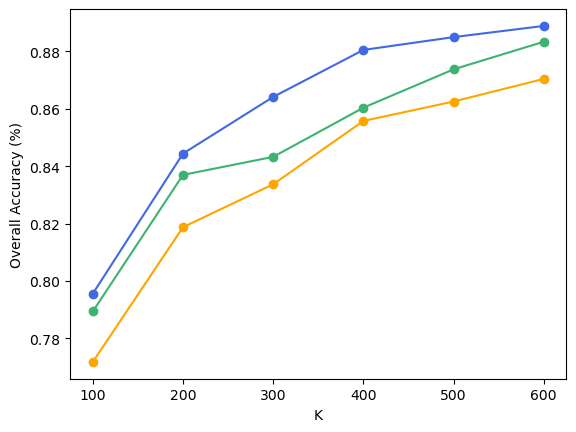

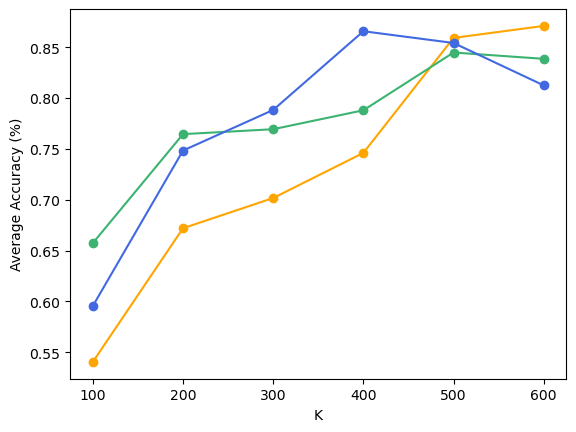

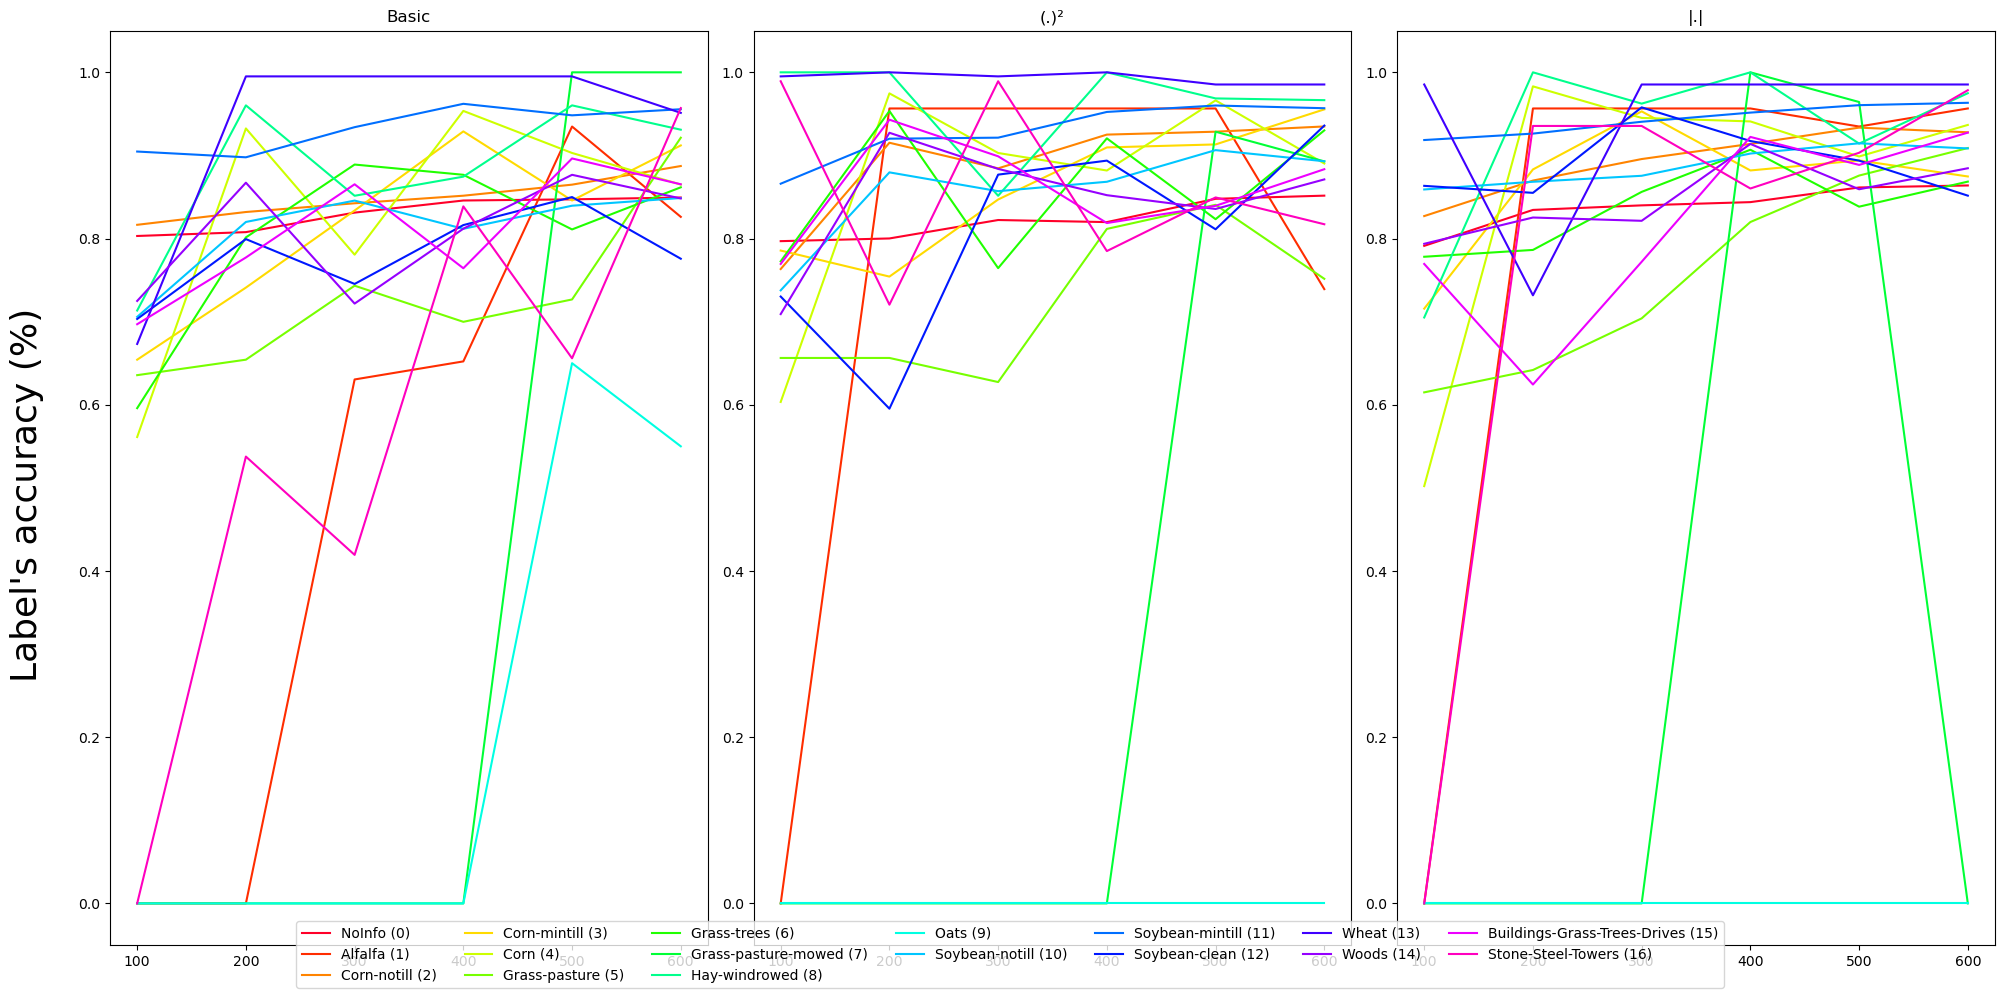

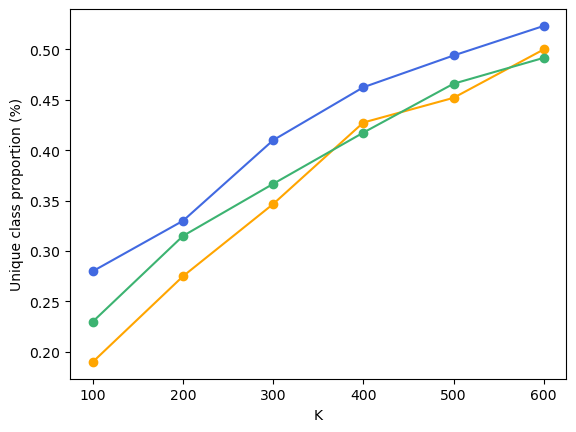

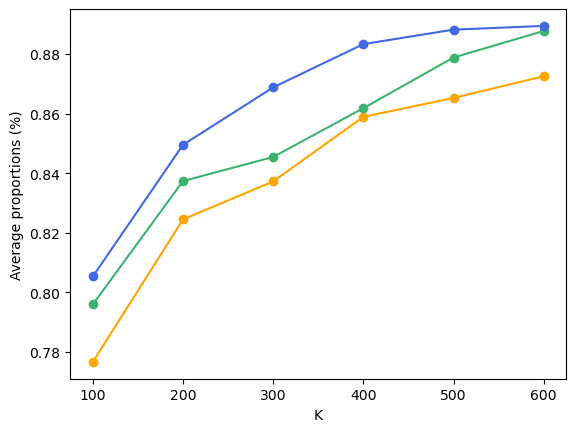

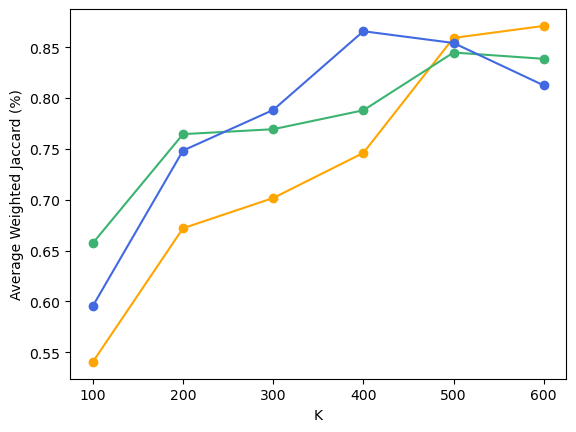

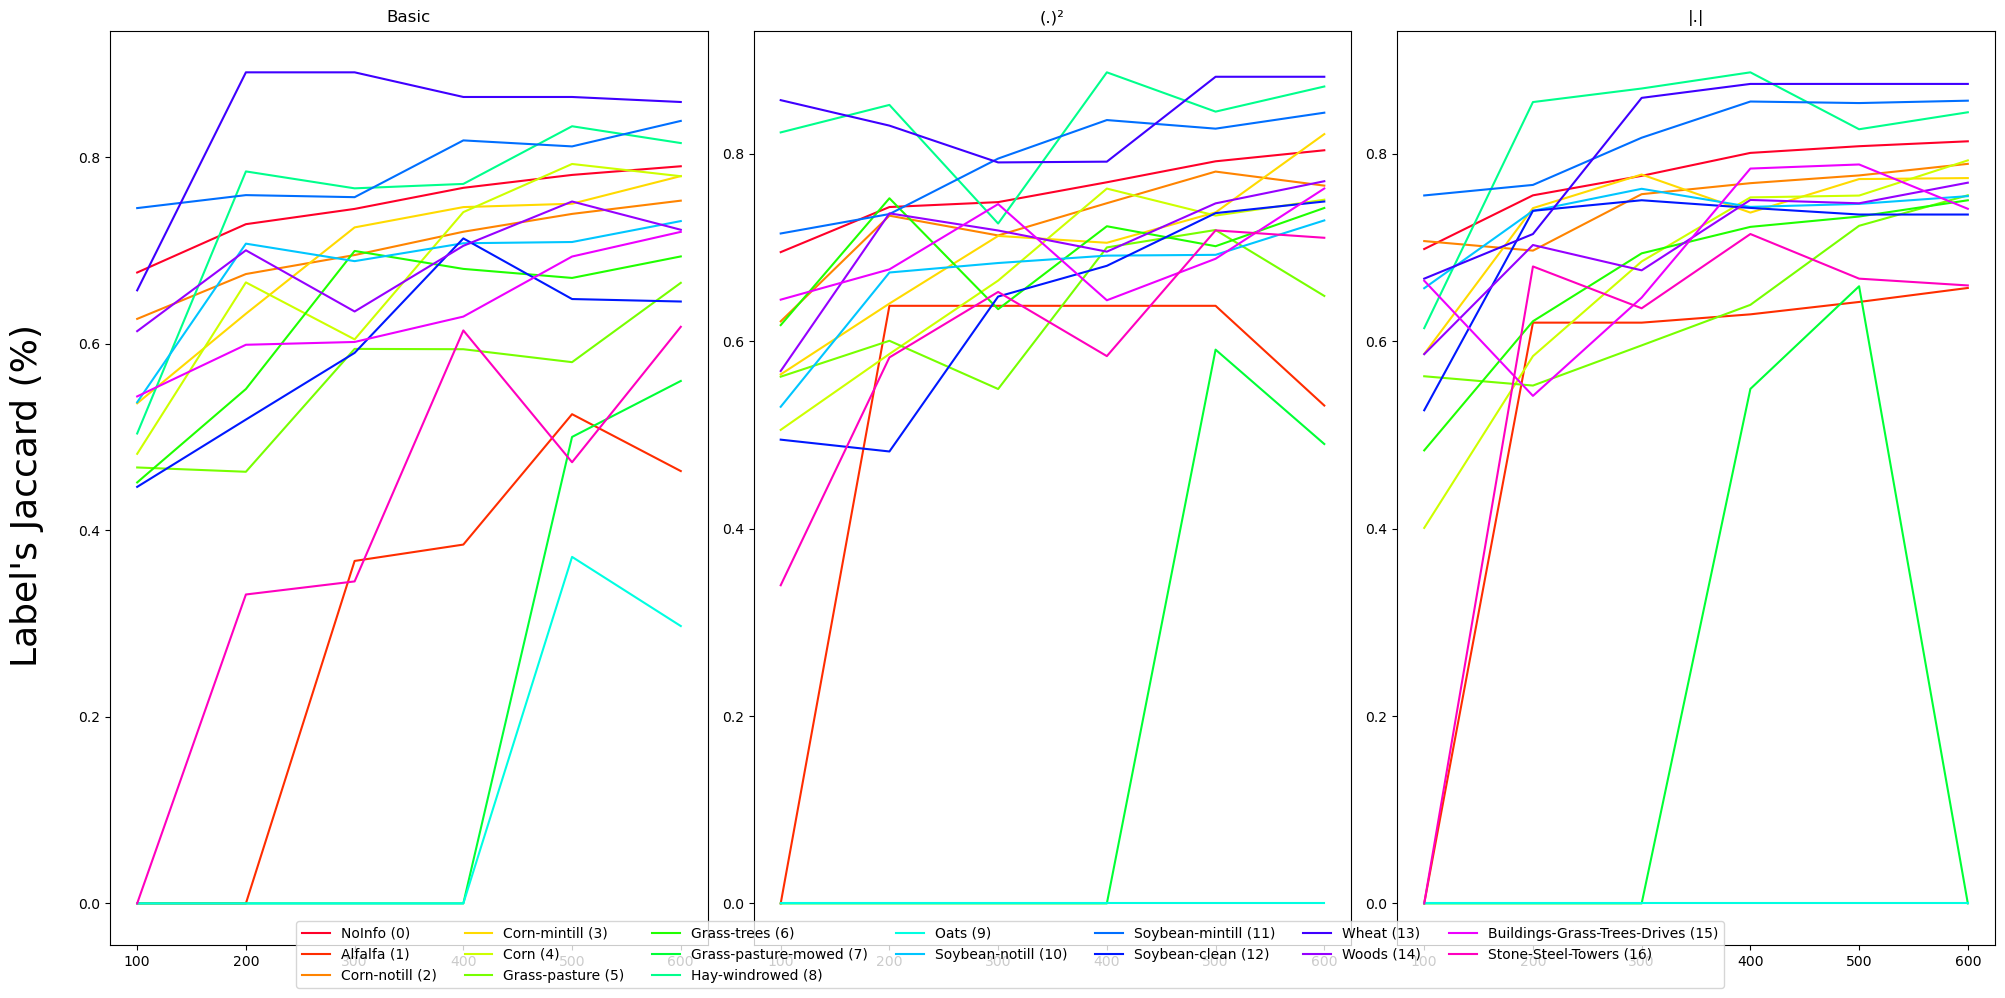

False


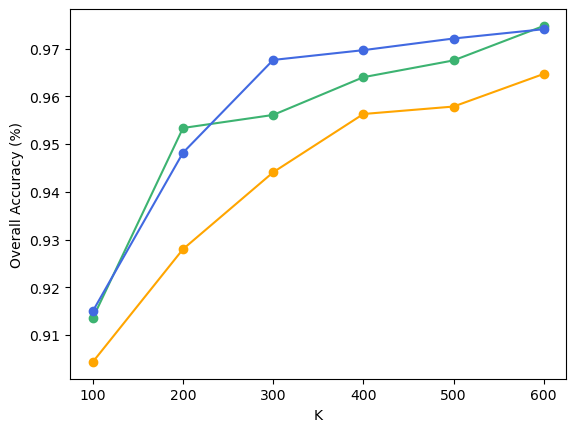

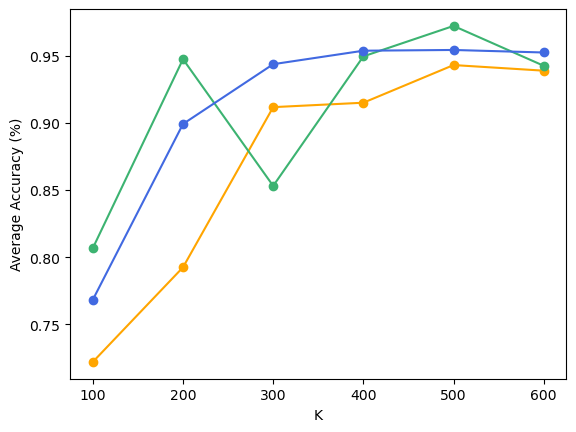

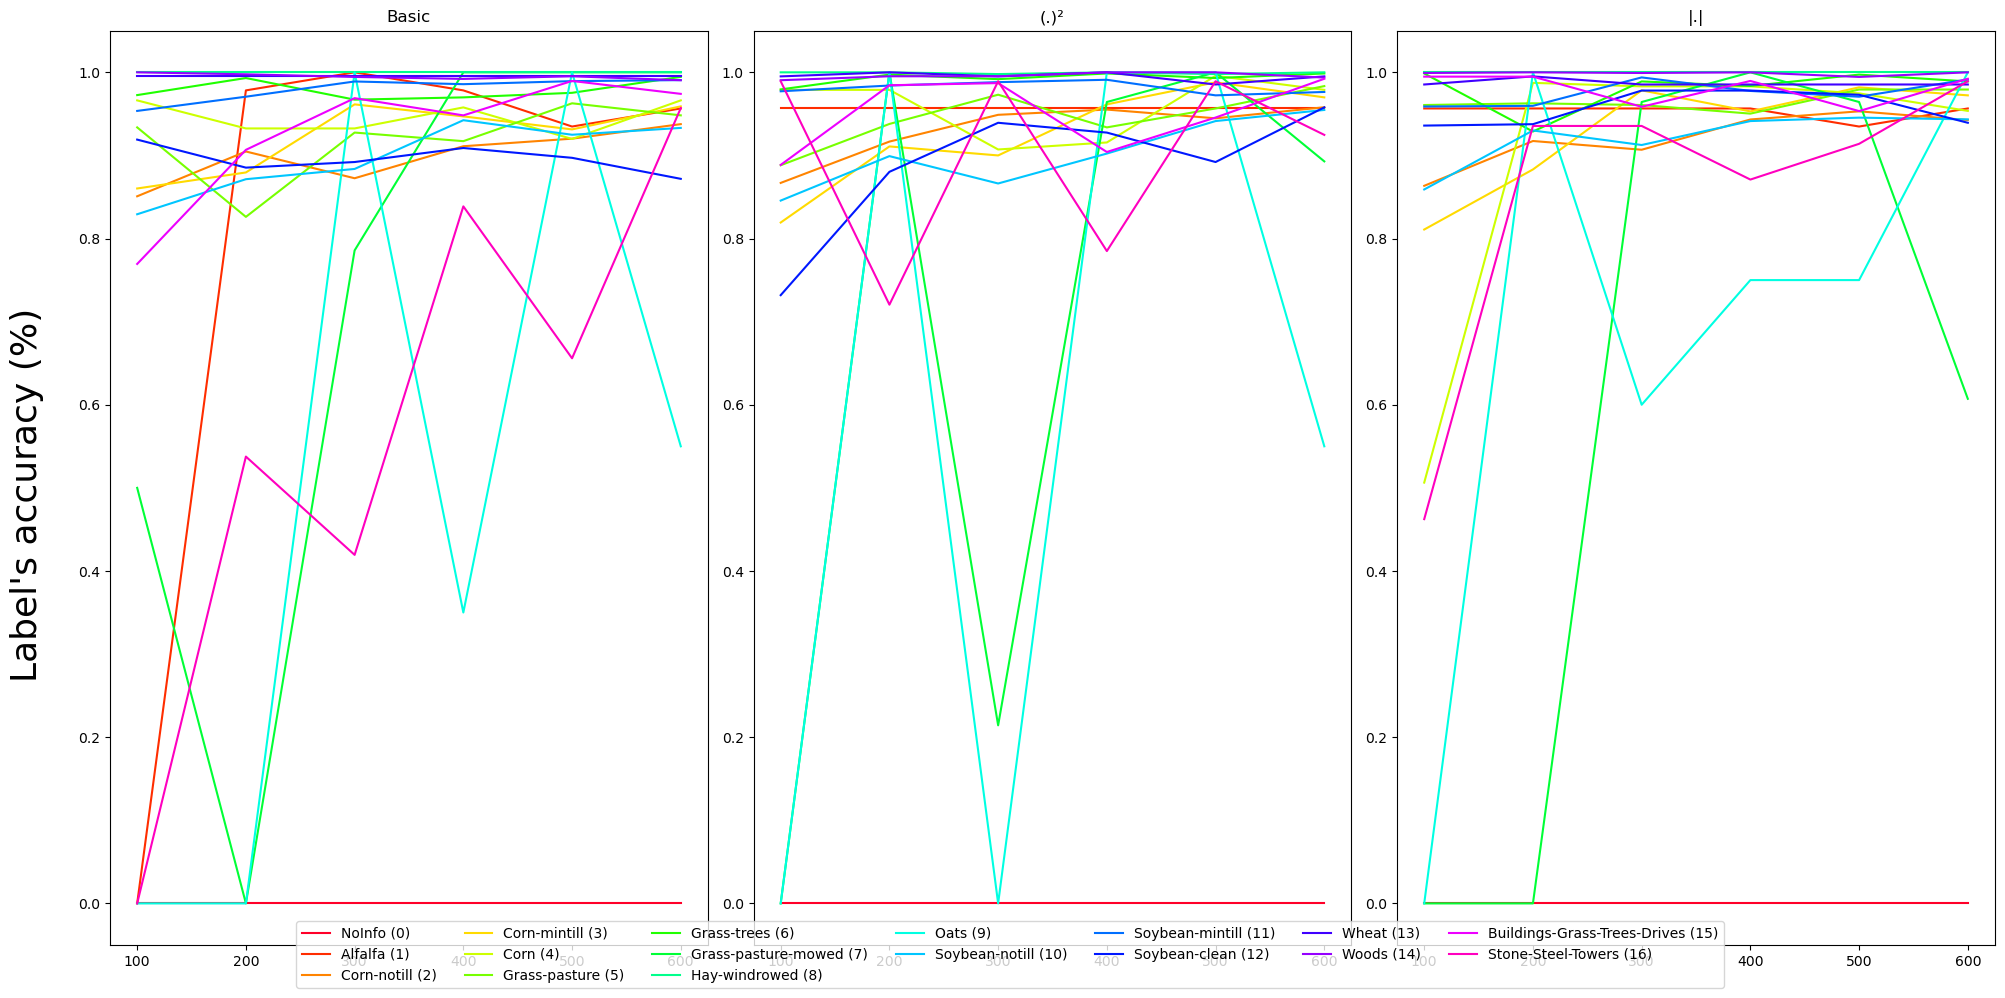

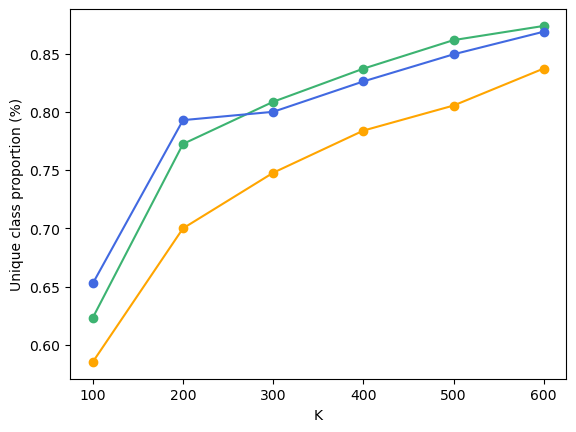

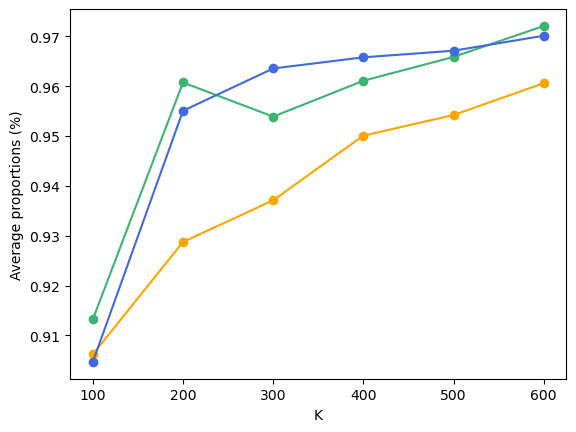

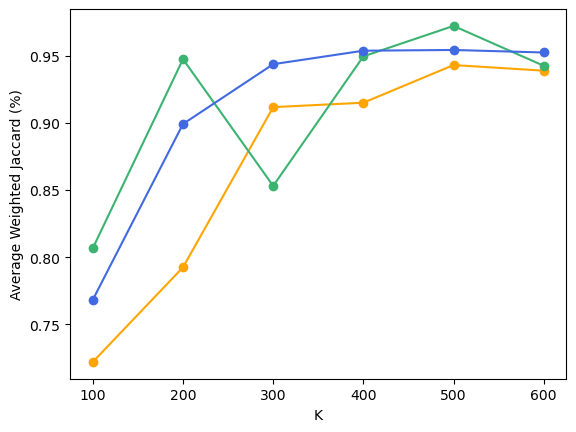

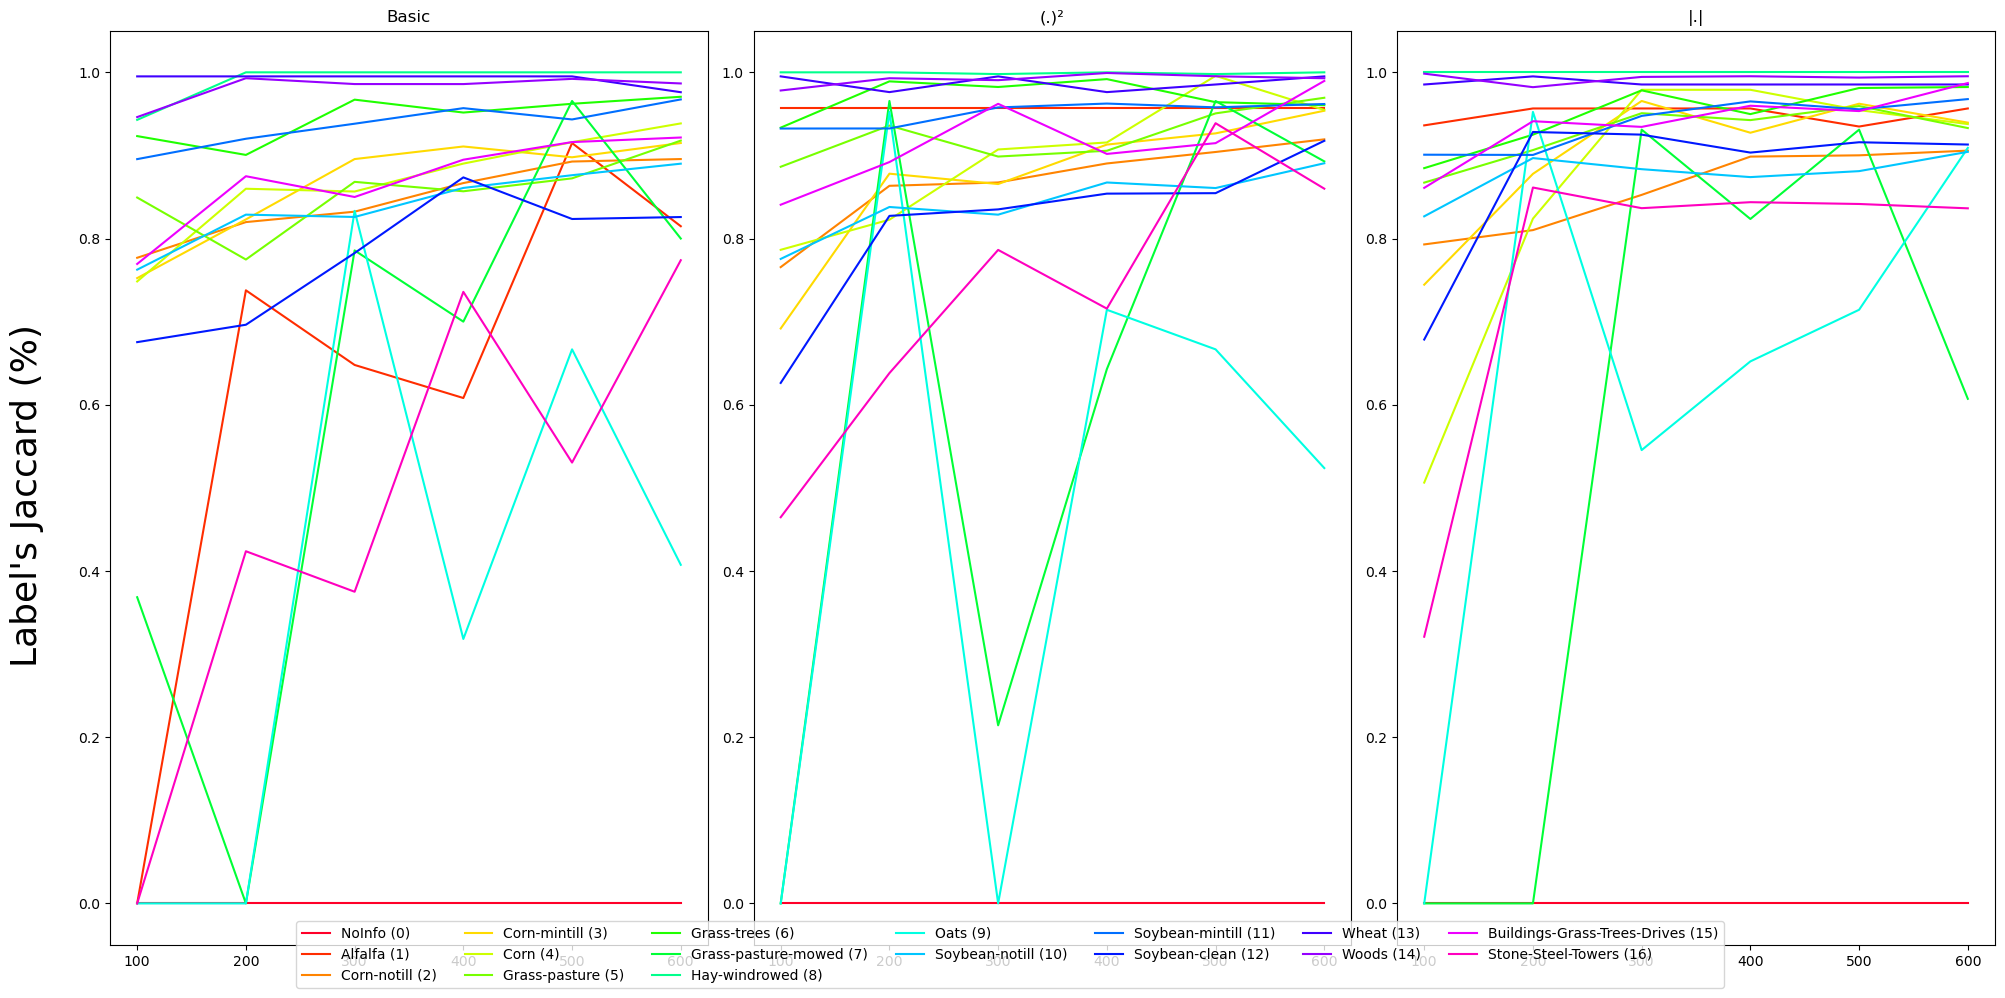

In [89]:
colors = ["orange", "mediumseagreen", "royalblue"]
def plot_info(info, ylabel="", plotbar=False):
    if plotbar:
        for k,K in enumerate(Ks):
            if K!=50:
                for d in range(size):
                    plt.bar(K+ d*20 -20, info[K][d], color=colors[d], width=20)
    else:
        length = len(info[Ks[0]])
        for i in range(length):
            plt.plot(Ks, [info[K][i] for K in Ks], "-o", color=colors[i])
            
    plt.xlabel("K")
    plt.ylabel(ylabel)
    plt.show()


def plot_label_info(info, ylabel=""):
    fig, axs = plt.subplots(1, len(datas), figsize=(20,10), sharex=True)
    for i in range(len(datas)):
        for label in usedDataset["labels"]:
            axs[i].plot(Ks, [info[label][K][i] for K in Ks], "-",
                         color=labels_color[label],
                         label=usedDataset["class"][label][0]+" ("+str(label)+")")
        axs[i].title.set_text(names[i])
    
    fig.text(0.0, 0.5, ylabel, va='center', rotation='vertical', fontsize=26)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.0))

    plt.tight_layout()
    plt.subplots_adjust(left=0.05)  
    plt.subplots_adjust(bottom=0.05)
    plt.show()



for i in range(len(datas)):
    plt.plot(0,len(datas)-i,"o", color=colors[i], label=names[i])
plt.legend()
plt.show()


plotBar = False
motifs = ["-o", "--s", ":^"]
cmap = mpl.colormaps["gist_rainbow"]
labels_color = cmap(np.linspace(0, 1, len(usedDataset["labels"])))
for b in [True, False]:
    print(b)
    plot_info(overallAccuracys[b], "Overall Accuracy (%)", plotbar=plotBar)
    plot_info(averageAccuracys[b], "Average Accuracy (%)", plotbar=plotBar)
    plot_label_info(labelsAccuracy[b], "Label's accuracy (%)")
    plot_info(singleClassCounts[b], "Unique class proportion (%)", plotbar=plotBar)
    plot_info(averageProportions[b], "Average proportions (%)", plotbar=plotBar)
    plot_info(averageAccuracys[b], "Average Weighted Jaccard (%)", plotbar=plotBar)
    plot_label_info(labelsJaccard[b], "Label's Jaccard (%)")

### GA result

In [90]:
import sklearn.utils
from sklearn.preprocessing import StandardScaler

def split_data(dataset, percent, bands):
    for_slices = [i for i in range(len(bands)) if bands[i]==1]
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    nb_info = sum([len(liste) for key,(_,liste) in dataset["class"].items() if key!=0])
    weights = {}
    for key, (name, liste) in dataset["class"].items():
        if key !=0:
            indices = np.zeros(len(liste), dtype=int)
            indices[:int(len(liste)*percent)] = 1

            np.random.shuffle(indices)

            weights[key] = nb_info/ len(liste)
            
            for i in range(len(liste)):
                data = dataset["data"][liste[i]]
                if indices[i]==1:
                    X_train.append(data[for_slices])
                    y_train.append(key)
                else:
                    X_test.append(data[for_slices])
                    y_test.append(key)

    X_train, y_train = sklearn.utils.shuffle(X_train, y_train, random_state=42)
    X_test, y_test = sklearn.utils.shuffle(X_test, y_test, random_state=42)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), weights
   
    


from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def SVM_accuracy(X_train,y_train, X_test,y_test):
    pipeline = Pipeline([
        ('scalar', StandardScaler()),
        ('svc', svm.SVC(kernel='rbf'))
    ])

    param_grid = {
        'svc__C': [0.1, 1, 10, 100, 1000, 2000, 4000],
        'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0005, 0.0001]
    }

    clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return len([0 for i in range(len(y_pred)) if y_pred[i]==y_test[i]]) /len(y_pred)


In [92]:
class Param:
    GN = 100
    NP = 100
    Pc = 0.9
    Pm1 = 0.02
    Pm2 = 0.1

pourcents = {
    Data.IndianPines["name"]: 0.05,
    Data.PaviaUniversity["name"]: 0.02,
    Data.PaviaCenter["name"]: 0.01
}

best_fitness = {K:[0 for _ in range(len(datas))] for K in Ks}
best_accuracy = {K:[0 for _ in range(len(datas))] for K in Ks}

trainingData = usedDataset["data"]
A = 1
for K in Ks:
    print("K:", K)
    for i in range(len(datas)):
        for a in range(A):
            print(a, end=" ")
            SPs = SPsDic[K][i]
            pop, fitness = SSGA(trainingData, 9, K, Param.GN, Param.NP, Param.Pc, Param.Pm1, Param.Pm2, False, SP=SPs)
            best_fitness[K][i] += fitness[0]

            bands = pop[0]
            X_train,y_train, X_test,y_test, weights = split_data(usedDataset, pourcents[usedDataset["name"]], bands)
            best_accuracy[K][i] += SVM_accuracy(X_train,y_train, X_test,y_test)

        best_fitness[K][i] /= A
        best_accuracy[K][i] /= A
        print()

K: 100
0 
0 
0 
K: 200
0 
0 
0 
K: 300
0 
0 
0 
K: 400
0 
0 
0 
K: 500
0 
0 
0 
K: 600
0 
0 
0 


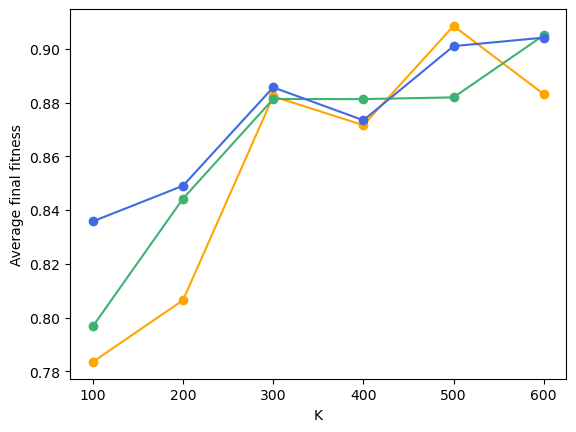

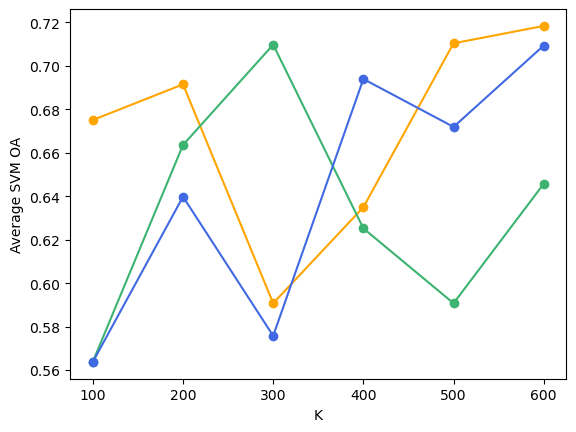

K = 100
[0.6750821018062397, 0.5638341543513957, 0.5637315270935961]
K = 200
[0.6915024630541872, 0.6635878489326765, 0.6397783251231527]
K = 300
[0.5907224958949097, 0.7097701149425287, 0.5757389162561576]
K = 400
[0.6349548440065681, 0.6252052545155994, 0.6939655172413793]
K = 500
[0.7103858784893268, 0.5907224958949097, 0.6719006568144499]
K = 600
[0.7183908045977011, 0.6457307060755336, 0.7093596059113301]


In [93]:
plot_info(best_fitness, "Average final fitness")
plot_info(best_accuracy, "Average SVM OA")
for K in Ks:
    print("K =", K)
    print(best_accuracy[K])

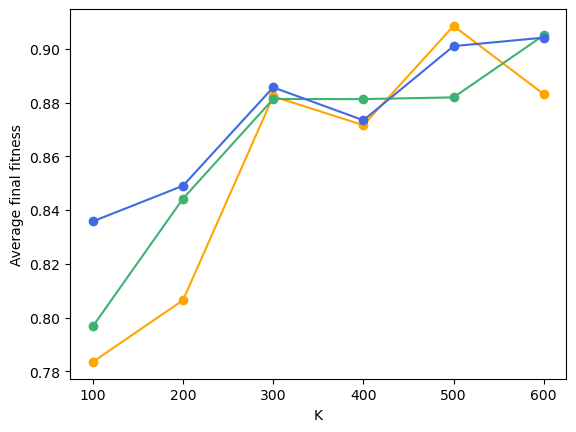

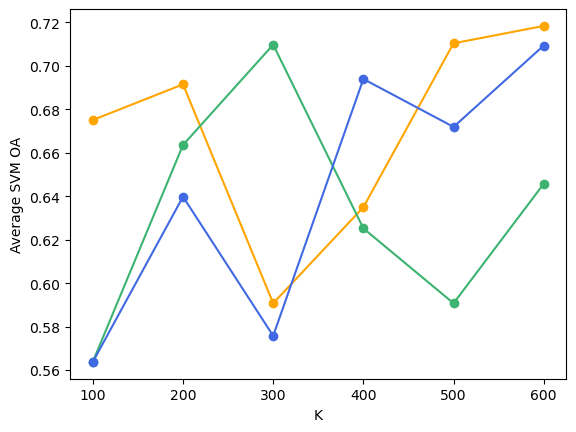

K = 100
[0.7834713363973511, 0.7967168666555082, 0.8358094086910718]
[0.6750821018062397, 0.5638341543513957, 0.5637315270935961]
K = 200
[0.8064494571957228, 0.8442916963779603, 0.8490633983121556]
[0.6915024630541872, 0.6635878489326765, 0.6397783251231527]
K = 300
[0.8823749844455685, 0.8813817767008838, 0.8857032833188622]
[0.5907224958949097, 0.7097701149425287, 0.5757389162561576]
K = 400
[0.8716255035506641, 0.8813404102262852, 0.8734611503455582]
[0.6349548440065681, 0.6252052545155994, 0.6939655172413793]
K = 500
[0.9085892963822589, 0.881979592275587, 0.9010695194829549]
[0.7103858784893268, 0.5907224958949097, 0.6719006568144499]
K = 600
[0.8831790834587359, 0.9051131705774633, 0.904231547213534]
[0.7183908045977011, 0.6457307060755336, 0.7093596059113301]


In [94]:
plot_info(best_fitness, "Average final fitness")
plot_info(best_accuracy, "Average SVM OA")
for K in Ks:
    print("K =", K)
    print(best_fitness[K])
    print(best_accuracy[K])